In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats


togo= pd.read_csv(r"data\togo-dapaong_qc.csv", parse_dates=["Timestamp"])

print(togo.head(7))

print(togo.dtypes)

print(togo.info())

print(togo.describe())

print(togo.isna().sum())




            Timestamp  GHI  DNI  DHI  ModA  ModB  Tamb    RH   WS  WSgust  \
0 2021-10-25 00:01:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.5  0.9     1.1   
1 2021-10-25 00:02:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.1     1.6   
2 2021-10-25 00:03:00 -1.3  0.0  0.0   0.0   0.0  24.8  94.4  1.2     1.4   
3 2021-10-25 00:04:00 -1.2  0.0  0.0   0.0   0.0  24.8  94.3  1.2     1.6   
4 2021-10-25 00:05:00 -1.2  0.0  0.0   0.0   0.0  24.8  94.0  1.3     1.6   
5 2021-10-25 00:06:00 -1.2  0.0  0.0   0.0   0.0  24.9  93.9  1.2     1.4   
6 2021-10-25 00:07:00 -1.1  0.0  0.0   0.0   0.0  24.9  93.8  1.2     1.4   

   WSstdev     WD  WDstdev   BP  Cleaning  Precipitation  TModA  TModB  \
0      0.4  227.6      1.1  977         0            0.0   24.7   24.4   
1      0.4  229.3      0.7  977         0            0.0   24.7   24.4   
2      0.3  228.5      2.9  977         0            0.0   24.7   24.4   
3      0.3  229.1      4.6  977         0            0.0   24.7   24.4   
4      0.4  2

In [5]:
num_cols = ["GHI", "DNI", "DHI", "ModA", "ModB", "Tamb", "RH", "WS", "WSgust", "WSstdev", "WD", "WDstdev", "BP", "Cleaning", "Precipitation", "TModA", "TModB"]

def count_outliers_iqr(df, columns):
    """
    Counts outliers in specified columns using the IQR method.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): List of column names to check

    Returns:
        dict: Dictionary with column names as keys and outlier counts as values
    """
    outlier_counts = {}

    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 1.5 * IQR
        upper = Q3 + 1.5 * IQR

        count = ((df[col] < lower) | (df[col] > upper)).sum()
        outlier_counts[col] = count
        print(round((count/len(df[col])) * 100, 2))

    print("\nOutlier Counts (IQR method):")
    for col, count in outlier_counts.items():
        print(f" - {col}: {count} outliers")


count_outliers_iqr(togo, num_cols)

0.25
9.62
1.5
0.24
0.29
0.0
0.0
1.66
1.4
2.79
0.0
1.32
3.66
0.05
0.64
0.03
0.11

Outlier Counts (IQR method):
 - GHI: 1303 outliers
 - DNI: 50586 outliers
 - DHI: 7905 outliers
 - ModA: 1237 outliers
 - ModB: 1537 outliers
 - Tamb: 0 outliers
 - RH: 0 outliers
 - WS: 8708 outliers
 - WSgust: 7377 outliers
 - WSstdev: 14669 outliers
 - WD: 0 outliers
 - WDstdev: 6921 outliers
 - BP: 19228 outliers
 - Cleaning: 281 outliers
 - Precipitation: 3338 outliers
 - TModA: 137 outliers
 - TModB: 573 outliers


In [ ]:
from scipy.stats import zscore

def count_outliers_zscore(df, columns):
    """
    Counts outliers in specified columns using the Z-score method.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        columns (list): List of column names to check

    Returns:
        dict: Dictionary with column names as keys and outlier counts as values
    """
    outlier_counts = {}

    for col in columns:
        z_scores = zscore(df[col].dropna())
        outliers = np.abs(z_scores) > 3
        count = outliers.sum()
        outlier_counts[col] = count
        print(round((count/len(df[col])) * 100, 2))
        
    print(f"\nOutlier Counts (Z-score method, threshold = 3):")
    for col, count in outlier_counts.items():
        print(f" - {col}: {count} outliers")


count_outliers_zscore(togo, num_cols)


#Plotting the outliers for a better view
for col in num_cols:
    z_scores = zscore(togo[col].dropna())
    outlier_mask = abs(z_scores) > 3

    # Get actual outlier values with their timestamps
    outliers = togo.loc[togo[col].dropna().index[outlier_mask], ['Timestamp', col]]

    # Plot
    plt.figure(figsize=(10, 4))
    plt.scatter(outliers['Timestamp'], outliers[col], color='red', label='Outliers')
    plt.xlabel('Timestamp')
    plt.ylabel(col)
    plt.title(f'Outliers in {col} (Z-score > 3)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

In [13]:
# Sort by column: 'Timestamp' (ascending)
togo = togo.sort_values(['Timestamp'])

# Drop column: 'Comments'
togo_clean = togo.drop(columns=['Comments'])

togo_clean.to_csv("data/togo_clean.csv", index=False)

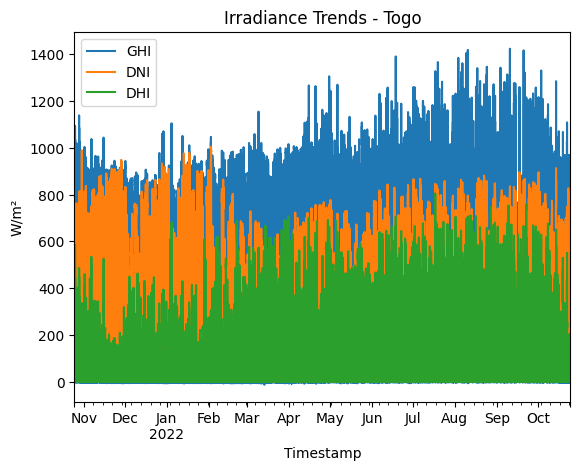

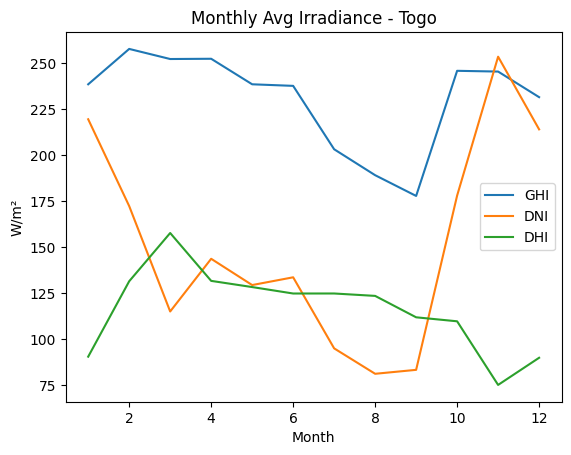

In [8]:
irradiance_cols = ['GHI', 'DNI', 'DHI']
togo_clean.set_index('Timestamp')[irradiance_cols].plot(title="Irradiance Trends - Togo")
plt.ylabel("W/m²")
plt.show()


togo_clean['Month'] = togo_clean['Timestamp'].dt.month

monthly_avg_TI = togo_clean.groupby('Month')[irradiance_cols].mean()
monthly_avg_TI.plot(title="Monthly Avg Irradiance - Togo")
plt.ylabel("W/m²")
plt.show()

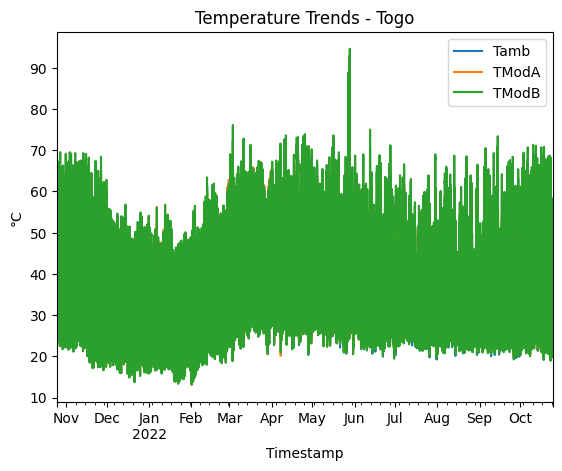

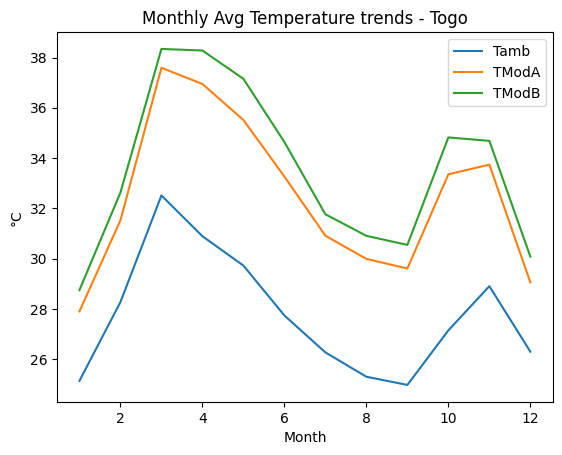

In [9]:
temp_cols = ['Tamb', 'TModA', 'TModB']
togo_clean.set_index('Timestamp')[temp_cols].plot(title="Temperature Trends - Togo")
plt.ylabel("°C")
plt.show()


monthly_avg_TT = togo_clean.groupby('Month')[temp_cols].mean()
monthly_avg_TT.plot(title="Monthly Avg Temperature trends - Togo")
plt.ylabel("°C")
plt.show()

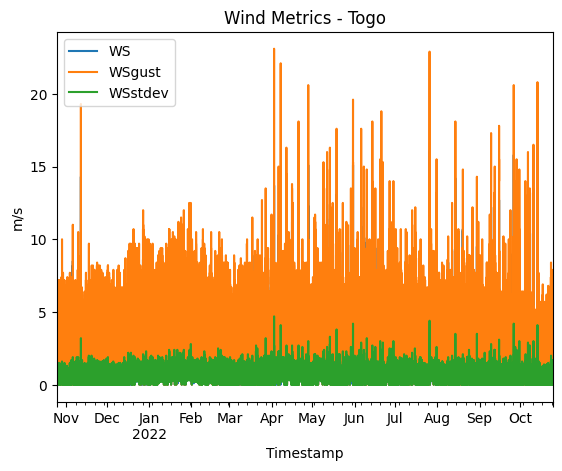

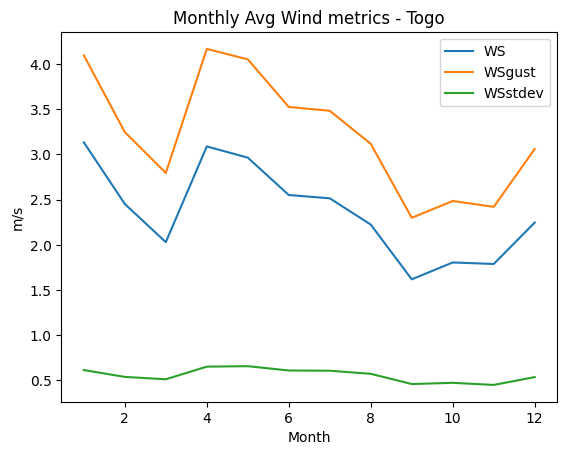

In [10]:
wind_cols = ['WS', 'WSgust', 'WSstdev']
togo_clean.set_index('Timestamp')[wind_cols].plot(title="Wind Metrics - Togo")
plt.ylabel("m/s")
plt.show()


monthly_avg_TW = togo_clean.groupby('Month')[wind_cols].mean()
monthly_avg_TW.plot(title="Monthly Avg Wind metrics - Togo")
plt.ylabel("m/s")
plt.show()

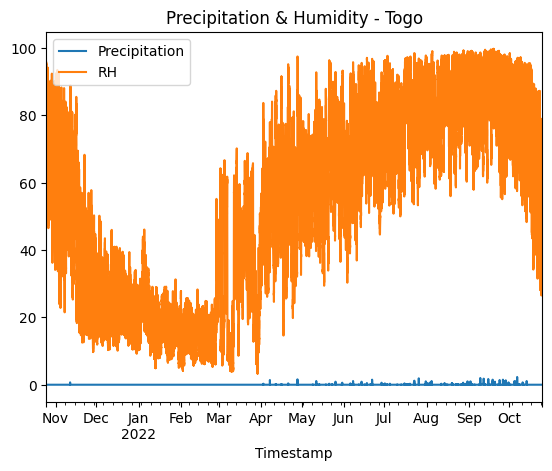

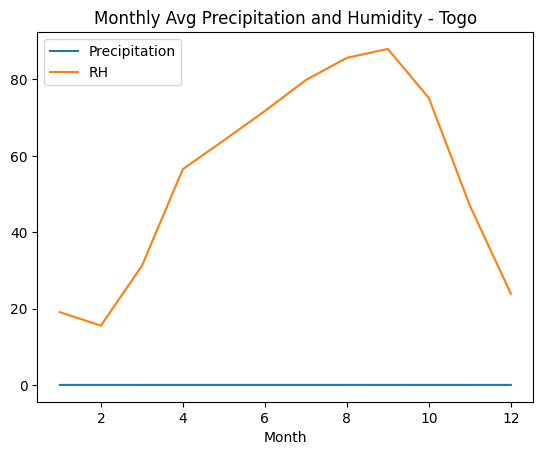

In [11]:
precip_cols = ['Precipitation', 'RH']
togo_clean.set_index('Timestamp')[precip_cols].plot(title="Precipitation & Humidity - Togo")
plt.show()


monthly_avg_TP = togo_clean.groupby('Month')[precip_cols].mean()
monthly_avg_TP.plot(title="Monthly Avg Precipitation and Humidity - Togo")
plt.show()

In [ ]:
# Group by Cleaning flag and plot average ModA & ModB

# Group and calculate mean
cleaning_impact = togo_clean.groupby('Cleaning')[['ModA', 'ModB']].mean().reset_index()

# Plot
cleaning_impact_melted = cleaning_impact.melt(id_vars='Cleaning', var_name='Module', value_name='Average Power')
sns.barplot(data=cleaning_impact_melted, x='Cleaning', y='Average Power', hue='Module')
plt.title("Average ModA & ModB Output Pre/Post Cleaning")
plt.xticks([0, 1], ['Before Cleaning', 'After Cleaning'])
plt.tight_layout()
plt.show()

In [ ]:
# Heatmap of Correlation Matrix

corr_cols = ['GHI', 'DNI', 'DHI', 'TModA', 'TModB']
sns.heatmap(togo_clean[corr_cols].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

In [ ]:
# Wind Speed vs. GHI
sns.scatterplot(data=togo_clean, x='WS', y='GHI')
plt.title('Wind Speed vs. GHI')
plt.show()

# Wind Gust vs. GHI
sns.scatterplot(data=togo_clean, x='WSgust', y='GHI')
plt.title('Wind Gust vs. GHI')
plt.show()

# Wind Direction vs. GHI
sns.scatterplot(data=togo_clean, x='WD', y='GHI')
plt.title('Wind Direction vs. GHI')
plt.show()

# RH vs Tamb
sns.scatterplot(data=togo_clean, x='RH', y='Tamb')
plt.title('RH vs. Ambient Temperature')
plt.show()

# RH vs GHI
sns.scatterplot(data=togo_clean, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()

In [ ]:
# Relationship: RH vs Tamb & RH vs GHI
sns.lmplot(data=togo_clean, x='RH', y='Tamb')
plt.title('RH vs. Temperature')
plt.show()

sns.lmplot(data=togo_clean, x='RH', y='GHI')
plt.title('RH vs. GHI')
plt.show()

In [ ]:
# Bubble Chart of GHI vs. Tamb with bubble size = RH

plt.figure(figsize=(10, 6))
sns.scatterplot(data=togo_clean, x='Tamb', y='GHI', size='RH', sizes=(10, 300), alpha=0.5)
plt.title('GHI vs Tamb (Bubble size = RH)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()


# Bubble Chart of GHI vs. Tamb with bubble size = BP

plt.figure(figsize=(10, 6))
sns.scatterplot(data=togo_clean, x='Tamb', y='GHI', size='BP', sizes=(10, 300), alpha=0.5)
plt.title('GHI vs Tamb (Bubble size = BP)')
plt.xlabel('Ambient Temperature (°C)')
plt.ylabel('GHI (W/m²)')
plt.tight_layout()
plt.show()